# Train a variational autoencoder to perform clustering on the MNIST data set.

With this exercises I'm trying to learn the basics of training an ANN with Keras.

I will define and train a VAE on the MNIST data set based on what I learned from the book "Deep Learning with Python" (available at https://livebook.manning.com/book/deep-learning-with-python-second-edition/deep-learning-with-python/).

Then I will perform clustering on the codings.

# Load some libraries and the MNIST data set

## Import libraries
Import the necessary libraries to run this notebook:

In [1]:
from tensorflow.keras.datasets import mnist

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import pandas as pd
import seaborn as sns

## Load and prepare the MNIST data set

Load de MNIST data set form Keras:

In [2]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

11490434/11490434 [==============================] - 0s 0us/step


Show the first image and some properties:

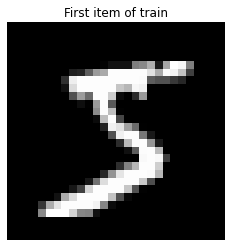

Label: 5
Shape: (28, 28)
Max/min: 255 0


In [3]:
plt.imshow(x_train[0].reshape(28,28))
plt.axis('off')
plt.set_cmap('gray')
plt.title("First item of train")
plt.show()
print("Label:", y_train[0])
print("Shape:", x_train[0].shape)
print("Max/min:", x_train[0].max(), x_train[0].min())

The VAE implements self-supervised learning, so we can train it with all the images on MNIST. We don't need to separete train and test sets. So we combine them all:

In [4]:
images = np.concatenate([x_train, x_test], axis=0)
labels = np.concatenate([y_train, y_test], axis=0)

We need to adapt the input to fit the network: add one dimension and rescale the values so the range from 0 to 1.

In [5]:
images = np.expand_dims(images, -1).astype("float")/255

We now have 70.000 images (and labels) to train the network.

In [6]:
print("images shape:", images.shape)
print("labels shape:", labels.shape)

images shape: (70000, 28, 28, 1)
labels shape: (70000,)


# VAE model

Since the input for the VAE will be an image, we will reuse de CNN architecture we found on the exercise "MNIST_classifier_CNN2".

## Define the encoder

We start by defining the encoder. It will take a 28x28 image as an input and otuput a two dimensional latent space that will define two normal distributions, defined by their mean an variance (taken as log variance).

In [7]:
# Some things we could tweak later:
conv_filters = [32, 64]
dropout_rate = 0.5
latent_dim = 2

# Input layer
encoder_inputs = keras.Input(shape=(28, 28, 1), name="inputs")
x = encoder_inputs

# Convolutional layers
for f in conv_filters:
    x = layers.Conv2D(f, 3,
                      padding="same",
                      activation="relu",
                      name="conv_1_"+str(f)) (x)
    x = layers.Conv2D(f, 3, 
                      padding="same", 
                      activation="relu",
                      name="conv_2_"+str(f)) (x)
    x = layers.Conv2D(f, 3, 
                      padding="same",
                      strides=2, 
                      activation="relu",
                      name="strides_"+str(f)) (x)
    x = layers.BatchNormalization(name="norm_"+str(f)) (x)
    x = layers.Dropout(dropout_rate, name="dropout_"+str(f)) (x)

# Dense layer before the output
x = layers.Flatten(name="flatten") (x)
x = layers.Dense(16, activation="relu", name="dense") (x)

# Output layers
z_mean = layers.Dense(latent_dim, name="z_mean") (x)
z_log_var = layers.Dense(latent_dim, name="z_log_var") (x)

# Define the encoder and show its summary
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv_1_32 (Conv2D)             (None, 28, 28, 32)   320         ['inputs[0][0]']                 
                                                                                                  
 conv_2_32 (Conv2D)             (None, 28, 28, 32)   9248        ['conv_1_32[0][0]']              
                                                                                                  
 strides_32 (Conv2D)            (None, 14, 14, 32)   9248        ['conv_2_32[0][0]']              
                                                                                            

## Define the decoder

We need a bridge layer between the encoder and the decoder. We need to sample a point from the distribution generated by the encoder, so we can feed it to the decoder.

In [8]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

No we can define the decoder. It will take as an input a points from the latent space and output a reconstruted image.

In [9]:
# Input layer
decoder_inputs = keras.Input(shape=(latent_dim,))

# Dense layers to revert the ones on the encoder
x = layers.Dense(7 * 7 * 64, activation="relu") (decoder_inputs)
x = layers.Reshape((7, 7, 64)) (x)

# Deconvolution layers
for f in conv_filters[::-1]: # reverse order
    x = layers.Conv2DTranspose(f, 3,
                               padding="same",
                               strides=2, 
                               activation="relu",
                               name="strides_1_"+str(f)) (x)
    x = layers.Conv2DTranspose(f, 3, 
                      padding="same", 
                      activation="relu",
                      name="deconv_1_"+str(f)) (x)
    x = layers.Conv2DTranspose(f, 3, 
                      padding="same", 
                      activation="relu",
                      name="deconv_2_"+str(f)) (x)
    x = layers.BatchNormalization(name="norm_"+str(f)) (x)
    x = layers.Dropout(dropout_rate, name="dropout_"+str(f)) (x)

    
# Output layer
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same") (x)

# Define the encoder and show its summary
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 strides_1_64 (Conv2DTranspo  (None, 14, 14, 64)       36928     
 se)                                                             
                                                                 
 deconv_1_64 (Conv2DTranspos  (None, 14, 14, 64)       36928     
 e)                                                              
                                                                 
 deconv_2_64 (Conv2DTranspos  (None, 14, 14, 64)       3692

## Define the VAE model

In [10]:
#ToDo: comment code
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
                "total_loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()
            }

## Train the model

Compile the model:

In [11]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)

Define a callbacks list to save the best performing model during training

In [12]:
# Note1: Saving the model is not that easy for a custom class. We'll have to look how we can do it.
# callbacks_list = [
#     # save the best model
#     keras.callbacks.ModelCheckpoint(
#         "vae.tf",
#         save_format="tf",
#         save_best_only = True,
#         monitor = "total_loss",
#     )
# ]

And train the model

In [13]:
# Load the already trained weights instead of re-training the model
vae.load_weights("model/vae_weights")

# vae.fit(images,
#         epochs=50,
#         batch_size=128,
#         # callbacks = callbacks_list, #See Note1 on previous chunck
#         verbose = 1,
#        )

Epoch 1/50
547/547 [==============================] - 45s 77ms/step - total_loss: 187.4200 - reconstruction_loss: 185.0526 - kl_loss: 2.3673
Epoch 2/50
547/547 [==============================] - 42s 76ms/step - total_loss: 154.3822 - reconstruction_loss: 151.0446 - kl_loss: 3.3377
Epoch 3/50
547/547 [==============================] - 42s 76ms/step - total_loss: 150.1628 - reconstruction_loss: 146.7523 - kl_loss: 3.4106
Epoch 4/50
547/547 [==============================] - 42s 76ms/step - total_loss: 147.9020 - reconstruction_loss: 144.4345 - kl_loss: 3.4675
Epoch 5/50
547/547 [==============================] - 42s 76ms/step - total_loss: 146.3805 - reconstruction_loss: 142.8654 - kl_loss: 3.5152
Epoch 6/50
547/547 [==============================] - 42s 76ms/step - total_loss: 145.4403 - reconstruction_loss: 141.8971 - kl_loss: 3.5432
Epoch 7/50
547/547 [==============================] - 42s 76ms/step - total_loss: 144.5749 - reconstruction_loss: 140.9995 - kl_loss: 3.5754
Epoch 8/50
54

## Visualize the latent space

Take points from a 30x30 grid on the latent space and regenerate the images. Save all of them on a single image.

In [157]:
n = 30
res = 28

img_latent_space = np.zeros((res * n, res * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::1]

for i, yi in enumerate(grid_y):
    print("decoding row", i+1, "of", n)
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(res, res)
        img_latent_space[i * res : (i + 1) * res,
                         j * res : (j + 1) * res] = digit

decoding row 1 of 30
decoding row 2 of 30
decoding row 3 of 30
decoding row 4 of 30
decoding row 5 of 30
decoding row 6 of 30
decoding row 7 of 30
decoding row 8 of 30
decoding row 9 of 30
decoding row 10 of 30
decoding row 11 of 30
decoding row 12 of 30
decoding row 13 of 30
decoding row 14 of 30
decoding row 15 of 30
decoding row 16 of 30
decoding row 17 of 30
decoding row 18 of 30
decoding row 19 of 30
decoding row 20 of 30
decoding row 21 of 30
decoding row 22 of 30
decoding row 23 of 30
decoding row 24 of 30
decoding row 25 of 30
decoding row 26 of 30
decoding row 27 of 30
decoding row 28 of 30
decoding row 29 of 30
decoding row 30 of 30


And show them.

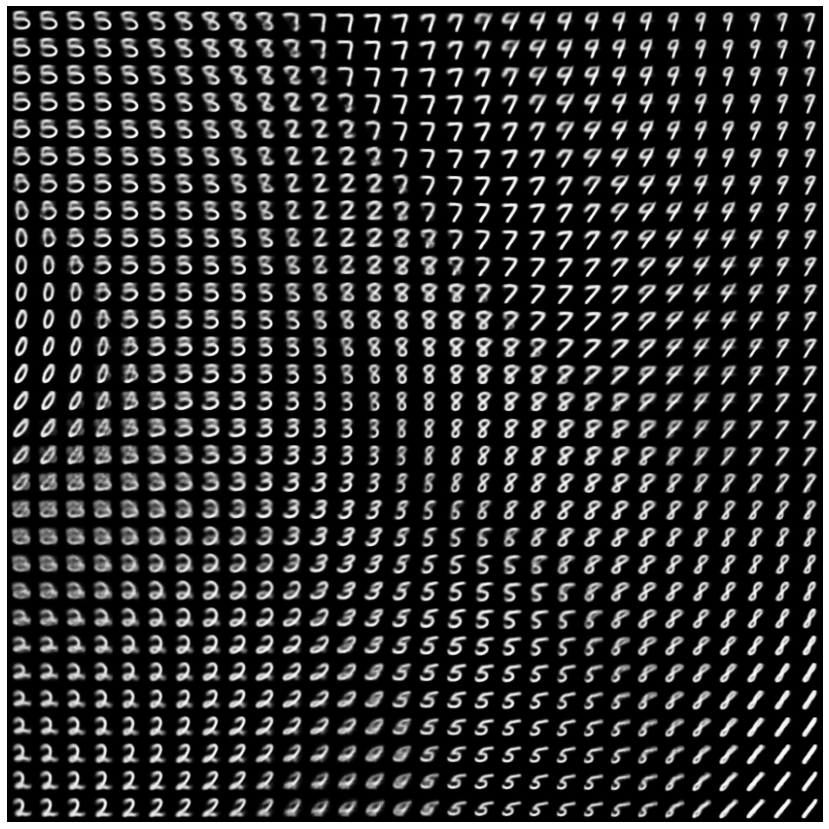

In [158]:
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.imshow(img_latent_space, cmap="Greys_r")

## Compare an original image with its reconstruction

1/1 [==============================] - 0s 23ms/step


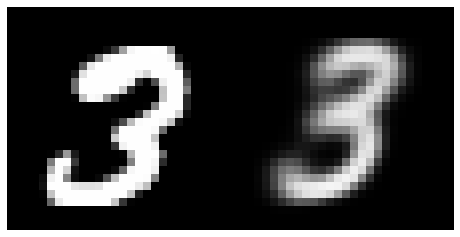

In [159]:
# Input image index (chose between 1 and 70.000)
num = 12345

res = 28
figure = np.zeros((res, res*2))

# Save the original image
figure[0:res, 0:res] = images[num].reshape(res, res)

# Encode it
z_mean, z_logvar = vae.encoder.predict(images[[num]])
# Decode it (use the predicted mean, no need to sample from the distribution)
x_decoded = vae.decoder.predict(z_mean)
# Save the the reconstructed image
reconstructed_img = x_decoded[0].reshape(res, res)
figure[0:res, res:res*2] = reconstructed_img

# Show original and reconstructed
plt.figure()
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

## Save the model and the codings

In [13]:
# Save the model
# vae.save("vae", save_format='tf') #gives error
vae.save_weights("model/vae_weights")

In [16]:
# Instantiate a new model and load the trained weigths
# newvae = VAE(encoder, decoder)
# newvae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
# newvae.load_weights("model/vae_weights")

In [160]:
# Generate the codings
codings_mean, codings_logvar = vae.encoder.predict(images)

2188/2188 [==============================] - 6s 3ms/step


In [ ]:
# Save them to a file for later
np.savetxt("codings/mean.csv", codings_mean)
np.savetxt("codings/logvar.csv", codings_logvar)

## Perform K-means clustering on embeddings

Try a range of `k` values and plot the SSE. We should expect good clustering with `k=10`.

computing for k = 3
computing for k = 4
computing for k = 5
computing for k = 6
computing for k = 7
computing for k = 8
computing for k = 9
computing for k = 10
computing for k = 11
computing for k = 12
computing for k = 13
computing for k = 14
computing for k = 15


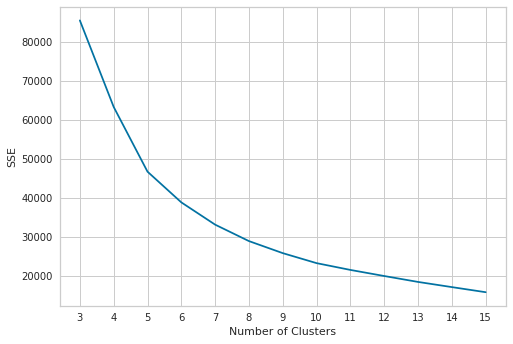

In [166]:
k_vals = np.arange(3, 16)
sse = []

for k in k_vals:
    print("computing for k =", k)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(codings_mean)
    sse.append(kmeans.inertia_)
    
plt.plot(k_vals, sse)
plt.xticks(k_vals)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

It looks like we have an elbow on k=7. We will take k=10 since we know we have 10 numbers in the data set.

We can make a contingency table of the clusters and the original labels and show it as a heatmap:

[Text(0.5, 28.5, 'clusters'), Text(51.0, 0.5, 'labels')]

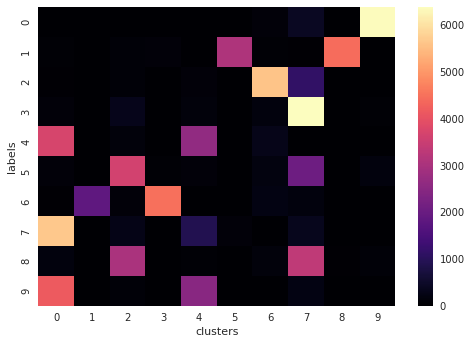

In [319]:
k=10

kmeans = KMeans(n_clusters=k)
kmeans.fit(codings_mean)

crosstab = pd.crosstab(labels, kmeans.labels_)
heatmap = sns.heatmap(crosstab,  cmap='magma')
heatmap.set(xlabel='clusters', ylabel='labels')

Also, we can take the centroid of each group and reconstruct the image with the decoder.

1/1 [==============================] - 0s 22ms/step


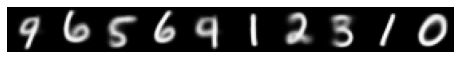

In [320]:
centroids = kmeans.cluster_centers_

res = 28
figure = np.zeros((res, res*k))

decoded_centroids = vae.decoder.predict(centroids)

for i,x in enumerate(decoded_centroids):
    reconstructed_img = x.reshape(res, res)
    figure[0:res, i*res:(i+1)*res] = reconstructed_img

# Show original and reconstructed
plt.figure()
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

Finally, we can draw each centroid reconstruction over the latent space representation:

decoding row 1 of 20
decoding row 2 of 20
decoding row 3 of 20
decoding row 4 of 20
decoding row 5 of 20
decoding row 6 of 20
decoding row 7 of 20
decoding row 8 of 20
decoding row 9 of 20
decoding row 10 of 20
decoding row 11 of 20
decoding row 12 of 20
decoding row 13 of 20
decoding row 14 of 20
decoding row 15 of 20
decoding row 16 of 20
decoding row 17 of 20
decoding row 18 of 20
decoding row 19 of 20
decoding row 20 of 20


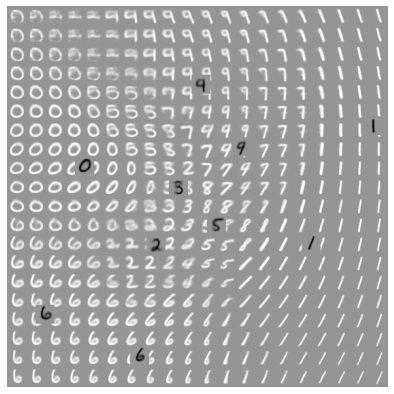

In [321]:
n = 20   # Number of points per row and column
res = 28 # Resolution of each reconstructed image
lim = 3  # Inferior and superior range for the latent space

# Initialize a blank image
im_res = n * res
img = np.zeros((im_res, im_res))

# Draw the latent space representation
grid_x = np.linspace(-1*lim, lim, n)
grid_y = np.linspace(-1*lim, lim, n)[::1]

for i, yi in enumerate(grid_y):
    print("decoding row", i+1, "of", n)
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(res, res)
        img[i*res : (i+1)*res,
            j*res : (j+1)*res] = digit

# Draw the centroids reconstrucions
for i,centroid in enumerate(centroids):
    y,x = ((centroid*n*res/lim+n*res)/2).astype("int")
    recon = decoded_centroids[i].reshape(res, res)
    recon = recon*(-1)
    img[x-res//2:x+res//2, y-res//2:y+res//2] = recon
        
# Show the image
plt.figure(figsize=(7, 7))
plt.axis("off")
plt.imshow(img, cmap="Greys_r")

# ToDo:

## Comment
- Comment chunk on 3.3, explain what we are doing.

## Save model
- Learn how to save a custom class model
- Redefine callbacks and try to train the model for longer, saving the best performance.

## Clustering
- Apply clustering to the latent space, see if the clusters relate to the labels
- Define clustering loss
- Retrain model